In [111]:
# Importieren wichtiger Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [112]:
data  = pd.read_csv("data.csv")
data.head()

,Zeitstempel,Filiale,Artikel,Menge,Umsatz,Bestellungen,Temperatur,Niederschlag,Globalstrahlung,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag
0,2016-01-03 08:01:46,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN
1,2016-01-03 08:04:45,Sulgen Filiale,Buttergipfeli,2.0,2.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN
2,2016-01-03 08:09:21,Sulgen Filiale,Buttergipfeli,12.0,15.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN
3,2016-01-03 08:11:19,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN
4,2016-01-03 08:11:19,Sulgen Filiale,Buttergipfeli,4.0,5.2,0.0,NaN,0.0,NaN,NaN,0.0,NaN


In [113]:
data_backup = data.copy()

# Transformation des Datensatzes
data["Zeitstempel"] = pd.to_datetime(data["Zeitstempel"])
data["Uhrzeit"] = pd.to_datetime(data["Zeitstempel"]).dt.time
data["Stunde"] = pd.to_datetime(data["Zeitstempel"]).dt.hour
data["Datum"] = pd.to_datetime(data["Zeitstempel"]).dt.date
data["Wochentag"] = pd.to_datetime(data["Zeitstempel"]).dt.day_name()

data.head()

,Zeitstempel,Filiale,Artikel,Menge,Umsatz,Bestellungen,Temperatur,Niederschlag,Globalstrahlung,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag
0,2016-01-03 08:01:46,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:01:46,8,2016-01-03,Sunday
1,2016-01-03 08:04:45,Sulgen Filiale,Buttergipfeli,2.0,2.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:04:45,8,2016-01-03,Sunday
2,2016-01-03 08:09:21,Sulgen Filiale,Buttergipfeli,12.0,15.6,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:09:21,8,2016-01-03,Sunday
3,2016-01-03 08:11:19,Sulgen Filiale,Butterzopf mittel,1.0,6.0,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday
4,2016-01-03 08:11:19,Sulgen Filiale,Buttergipfeli,4.0,5.2,0.0,NaN,0.0,NaN,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday


In [114]:
# Konvertieren der Spalten in die richtige Datentypen
data["Datum"] = pd.to_datetime(data["Datum"]).dt.date
wochentag_reihenfolge = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data["Wochentag"] = pd.Categorical(data["Wochentag"], categories = wochentag_reihenfolge, ordered = True)
data['Monat'] = pd.to_datetime(data['Datum']).dt.month

# Entfernen nicht mehr benötigter Spalten
data = data.drop(columns = ["Filiale", "Zeitstempel"], axis = "columns")

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 727754 entries, 0 to 727753
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Artikel                      727754 non-null  object  
 1   Menge                        727754 non-null  float64 
 2   Umsatz                       727754 non-null  float64 
 3   Bestellungen                 727754 non-null  float64 
 4   Temperatur                   718722 non-null  float64 
 5   Niederschlag                 725226 non-null  float64 
 6   Globalstrahlung              718722 non-null  float64 
 7   Temperatur Schnitt Tag       719687 non-null  float64 
 8   Niederschlag Summe Tag       727754 non-null  float64 
 9   Globalstrahlung Schnitt Tag  719687 non-null  float64 
 10  Uhrzeit                      727754 non-null  object  
 11  Stunde                       727754 non-null  int64   
 12  Datum                        727754 non-null

In [115]:
# Im nächsten Schritt prüfen wir Transaktionen außerhalb der Öffnungszeiten. Im Maximum hat die Bäckerrei von 5:30 bis 19:00 geöffnet.
# Zu erst werden Transaktionen vor Öffnung geprüft.
data_4_uhr = data[data["Stunde"] == 4]
data_4_uhr.head()

# Da sich in einem Histogramm über den Umsatz pro Uhrzeit pro Tag Ausreißer um 4 Uhr finden, werden alle Einträge vor 5 Uhr entfernt.
data = data[data["Stunde"] >= 5]

# 
data_20_uhr = data[data["Stunde"] == 20]
data_20_uhr.head()

#Duplikate entfernen

data.drop_duplicates(inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 719185 entries, 0 to 727753
Data columns (total 15 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Artikel                      719185 non-null  object  
 1   Menge                        719185 non-null  float64 
 2   Umsatz                       719185 non-null  float64 
 3   Bestellungen                 719185 non-null  float64 
 4   Temperatur                   710279 non-null  float64 
 5   Niederschlag                 716688 non-null  float64 
 6   Globalstrahlung              710279 non-null  float64 
 7   Temperatur Schnitt Tag       711227 non-null  float64 
 8   Niederschlag Summe Tag       719185 non-null  float64 
 9   Globalstrahlung Schnitt Tag  711227 non-null  float64 
 10  Uhrzeit                      719185 non-null  object  
 11  Stunde                       719185 non-null  int64   
 12  Datum                        719185 non-null

In [116]:
# neue Kolumnen für Temperatur und Globalstrahlung einfügen
data = data.drop(columns = ["Temperatur", "Globalstrahlung"], axis = "columns")
data.head()

,Artikel,Menge,Umsatz,Bestellungen,Niederschlag,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag,Monat
0,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:01:46,8,2016-01-03,Sunday,1
1,Buttergipfeli,2.0,2.6,0.0,0.0,NaN,0.0,NaN,08:04:45,8,2016-01-03,Sunday,1
2,Buttergipfeli,12.0,15.6,0.0,0.0,NaN,0.0,NaN,08:09:21,8,2016-01-03,Sunday,1
3,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday,1
4,Buttergipfeli,4.0,5.2,0.0,0.0,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday,1


In [117]:
# Stückpreis berechnet
data["Stückpreis"] = pd.to_numeric(data["Umsatz"] / data["Menge"]).apply(lambda x: '{:.2f}'.format(x))

# Sortieren nach Stückpreis
data_preis = data.sort_values(by='Stückpreis', ascending=True)

In [118]:
n_produkte = data["Artikel"].unique()

# Erstellen einer Produktliste mit der verkauften Anzahl
produkt_liste = data[["Artikel", "Menge"]].groupby("Artikel").sum().sort_values(by="Menge", ascending=False).reset_index()


print("Es sind folgende Produkte im Datensatz enthalten: ")
print(produkt_liste)

Es sind folgende Produkte im Datensatz enthalten: 
                   Artikel     Menge
0            Buttergipfeli  380642.5
1       Laugengi.mit SoBlu  186385.0
2               Maisgipfel  179040.6
3             Laugenbrötli   95742.5
4            Weggli normal   83048.0
5          St. Gallerbürli   79097.0
6           Crèmeschnitten   70883.0
7            BT Nussgipfel   63750.3
8              Quarkzöpfli   62926.0
9        Butterzopf mittel   62808.0
10           Schoggibrötli   43800.0
11  Il pollo forte gefüllt   42087.0
12     Hefe-Vanille-Weggli   39990.0
13           Erdbeertörtli   26792.0


## 2.3 Hinzufügen weiterer Features

### 2.3.0 Feiertage

Quelle: https://www.feiertagskalender.ch/index.php?geo=2173&jahr=2016&klasse=5&hl=de
Noch ohne Fasnacht

In [119]:
import pandas as pd

# Read the CSV file into a pandas dataframe
holidays_df = pd.read_csv('Liste_Feiertage.csv', delimiter=';')

# Convert the Date column to datetime format
holidays_df['Datum'] = pd.to_datetime(holidays_df['Datum'])

# Create a list of holiday dates
holiday_dates = holidays_df['Datum'].dt.strftime('%Y-%m-%d').tolist()

# Print the list of holiday dates
holidays_df.head()

C:\Users\marin\AppData\Local\Temp\ipykernel_5996\2066207441.py:7: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  holidays_df['Datum'] = pd.to_datetime(holidays_df['Datum'])


,Datum,Feiertag
0,2016-01-01,Neujahrstag
1,2016-02-01,Berchtoldstag
2,2016-06-01,Dreikönigstag
3,2016-03-20,Palmsonntag
4,2016-02-14,Valentinstag


Nun wird dem Dataframe eine neue Spalte beigefügt. Je nachdem, ob der Tag ein Feiertag ist oder nicht, wird jeweils eine 1 (Feiertag) oder eine 0 (kein Feiertag) eingefügt.


In [120]:
import pandas as pd

data['Feiertag'] = ''

#If the date is in the list of holiday dates, then set the holiday column to 1, otherwise 0

for index, row in data.iterrows():
    if row['Datum'].strftime('%Y-%m-%d') in holiday_dates:
        data.at[index, 'Feiertag'] = 1
    else:
        data.at[index, 'Feiertag'] = 0

data.head()

,Artikel,Menge,Umsatz,Bestellungen,Niederschlag,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag,Monat,Stückpreis,Feiertag
0,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:01:46,8,2016-01-03,Sunday,1,6.00,0
1,Buttergipfeli,2.0,2.6,0.0,0.0,NaN,0.0,NaN,08:04:45,8,2016-01-03,Sunday,1,1.30,0
2,Buttergipfeli,12.0,15.6,0.0,0.0,NaN,0.0,NaN,08:09:21,8,2016-01-03,Sunday,1,1.30,0
3,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday,1,6.00,0
4,Buttergipfeli,4.0,5.2,0.0,0.0,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday,1,1.30,0


### 2.3.1 Schulferien

In [121]:
import datetime
erstes_datum = data['Datum'].min()
letztes_datum = data['Datum'].max()

print("Das erste Datum im Datensatz ist:", erstes_datum)
print("Das letzte Datum im Datensatz ist:", letztes_datum)

# Daten von https://av.tg.ch/public/upload/assets/8713/10_Jahresplan_Schulferien_Volksschule_2019_-_2029.pdf?fp=3
# Daten von https://www.schulferien.org/schweiz/kalender/thurgau/2019/

# Ferienlisten nach Ferienzeit erstellen

gesamtliste_herbstferien = []
gesamtliste_weihnachtsferien = []
gesamtliste_sportferien = []
gesamtliste_fruehlingsferien = []
gesamtliste_pfingstferien = []
gesamtliste_sommerferien = []


Das erste Datum im Datensatz ist: 2016-01-03
Das letzte Datum im Datensatz ist: 2022-02-11


#### Schuljahr 2015/ 2016

In [122]:
# Herbstferien Schuljahr 2015 / 2016
# brauchen wir nicht

# Weihnachtsferien Schuljahr 2015 / 2016
ferienbeginn_weihnachten2015_2016 = datetime.date(2015, 12, 24)
ferienende_weihnachten2015_2016 = datetime.date(2016, 1, 3)

current_date = ferienbeginn_weihnachten2015_2016
weihnachtsferien_tg_sj_2015_2016 = []

while current_date <= ferienende_weihnachten2015_2016:
    weihnachtsferien_tg_sj_2015_2016.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sportferien Schuljahr 2015 / 2016
ferienbeginn_sport2015_2016 = datetime.date(2016, 2, 1)
ferienende_sport2015_2016 = datetime.date(2016, 2, 7)

current_date = ferienbeginn_sport2015_2016
sportferien_tg_sj_2015_2016 = []

while current_date <= ferienende_sport2015_2016:
    sportferien_tg_sj_2015_2016.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Frühlingsferien Schuljahr 2015 / 2016
ferienbeginn_fruehling2015_2016 = datetime.date(2016, 3, 25)
ferienende_fruehling2015_2016 = datetime.date(2016, 4, 10)

current_date = ferienbeginn_fruehling2015_2016
fruehlingsferien_tg_sj_2015_2016 = []

while current_date <= ferienende_fruehling2015_2016:
    fruehlingsferien_tg_sj_2015_2016.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Pfingstferien Schuljahr 2015 / 2016
ferienbeginn_pfingsten2015_2016 = datetime.date(2016, 5, 5)
ferienende_pfingsten2015_2016 = datetime.date(2016, 5, 16)

current_date = ferienbeginn_pfingsten2015_2016
pfingstferien_tg_sj_2015_2016 = []

while current_date <= ferienende_pfingsten2015_2016:
    pfingstferien_tg_sj_2015_2016.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sommerferien Schuljahr 2015 / 2016
ferienbeginn_sommer2015_2016 = datetime.date(2016, 7, 11)
ferienende_sommer2015_2016 = datetime.date(2016, 8, 14)

current_date = ferienbeginn_sommer2015_2016
sommerferien_tg_sj_2015_2016 = []

while current_date <= ferienende_sommer2015_2016:
    sommerferien_tg_sj_2015_2016.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)


gesamtliste_weihnachtsferien.extend(weihnachtsferien_tg_sj_2015_2016)
gesamtliste_sportferien.extend(sportferien_tg_sj_2015_2016)
gesamtliste_fruehlingsferien.extend(fruehlingsferien_tg_sj_2015_2016)
gesamtliste_pfingstferien.extend(pfingstferien_tg_sj_2015_2016)
gesamtliste_sommerferien.extend(sommerferien_tg_sj_2015_2016)

#### Schuljahr 2016/ 2017

In [123]:
# Herbstferien Schuljahr 2016 / 2017
ferienbeginn_herbst2016_2017 = datetime.date(2016, 10, 10)
ferienende_herbst2016_2017 = datetime.date(2016, 10, 23)

current_date = ferienbeginn_herbst2016_2017
herbstferien_tg_sj_2016_2017 = []

while current_date <= ferienende_herbst2016_2017:
    herbstferien_tg_sj_2016_2017.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Weihnachtsferien Schuljahr 2016 / 2017
ferienbeginn_weihnachten2016_2017 = datetime.date(2016, 12, 26)
ferienende_weihnachten2016_2017 = datetime.date(2017, 1, 8)

current_date = ferienbeginn_weihnachten2016_2017
weihnachtsferien_tg_sj_2016_2017 = []

while current_date <= ferienende_weihnachten2016_2017:
    weihnachtsferien_tg_sj_2016_2017.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sportferien Schuljahr 2016 / 2017
ferienbeginn_sport2016_2017 = datetime.date(2017, 1, 30)
ferienende_sport2016_2017 = datetime.date(2017, 2, 5)

current_date = ferienbeginn_sport2016_2017
sportferien_tg_sj_2016_2017 = []

while current_date <= ferienende_sport2016_2017:
    sportferien_tg_sj_2016_2017.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Frühlingsferien Schuljahr 2016 / 2017
ferienbeginn_fruehling2016_2017 = datetime.date(2017, 4, 3)
ferienende_fruehling2016_2017 = datetime.date(2017, 4, 17)

current_date = ferienbeginn_fruehling2016_2017
fruehlingsferien_tg_sj_2016_2017 = []

while current_date <= ferienende_fruehling2016_2017:
    fruehlingsferien_tg_sj_2016_2017.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Pfingstferien Schuljahr 2016 / 2017
ferienbeginn_pfingsten2016_2017 = datetime.date(2017, 5, 25)
ferienende_pfingsten2016_2017 = datetime.date(2017, 6, 5)

current_date = ferienbeginn_pfingsten2016_2017
pfingstferien_tg_sj_2016_2017 = []

while current_date <= ferienende_pfingsten2016_2017:
    pfingstferien_tg_sj_2016_2017.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sommerferien Schuljahr 2016 / 2017
ferienbeginn_sommer2016_2017 = datetime.date(2017, 7, 10)
ferienende_sommer2016_2017 = datetime.date(2017, 8, 13)

current_date = ferienbeginn_sommer2016_2017
sommerferien_tg_sj_2016_2017 = []

while current_date <= ferienende_sommer2016_2017:
    sommerferien_tg_sj_2016_2017.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

gesamtliste_herbstferien.extend(herbstferien_tg_sj_2016_2017)
gesamtliste_weihnachtsferien.extend(weihnachtsferien_tg_sj_2016_2017)
gesamtliste_sportferien.extend(sportferien_tg_sj_2016_2017)
gesamtliste_fruehlingsferien.extend(fruehlingsferien_tg_sj_2016_2017)
gesamtliste_pfingstferien.extend(pfingstferien_tg_sj_2016_2017)
gesamtliste_sommerferien.extend(sommerferien_tg_sj_2016_2017)



#### Schuljahr 2017/ 2018

In [124]:
# Herbstferien Schuljahr 2017 / 2018
ferienbeginn_herbst2017_2018 = datetime.date(2017, 10, 9)
ferienende_herbst2017_2018 = datetime.date(2017, 10, 22)

current_date = ferienbeginn_herbst2017_2018
herbstferien_tg_sj_2017_2018 = []

while current_date <= ferienende_herbst2017_2018:
    herbstferien_tg_sj_2017_2018.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Weihnachtsferien Schuljahr 2017 / 2018
ferienbeginn_weihnachten2017_2018 = datetime.date(2017, 12, 25)
ferienende_weihnachten2017_2018 = datetime.date(2018, 1, 7)

current_date = ferienbeginn_weihnachten2017_2018
weihnachtsferien_tg_sj_2017_2018 = []

while current_date <= ferienende_weihnachten2017_2018:
    weihnachtsferien_tg_sj_2017_2018.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sportferien Schuljahr 2017 / 2018
ferienbeginn_sport2017_2018 = datetime.date(2018, 1, 29)
ferienende_sport2017_2018 = datetime.date(2018, 2, 4)

current_date = ferienbeginn_sport2017_2018
sportferien_tg_sj_2017_2018 = []

while current_date <= ferienende_sport2017_2018:
    sportferien_tg_sj_2017_2018.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Frühlingsferien Schuljahr 2017 / 2018
ferienbeginn_fruehling2017_2018 = datetime.date(2018, 3, 30)
ferienende_fruehling2017_2018 = datetime.date(2018, 4, 15)

current_date = ferienbeginn_fruehling2017_2018
fruehlingsferien_tg_sj_2017_2018 = []

while current_date <= ferienende_fruehling2017_2018:
    fruehlingsferien_tg_sj_2017_2018.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Pfingstferien Schuljahr 2017 / 2018
ferienbeginn_pfingsten2017_2018 = datetime.date(2018, 5, 10)
ferienende_pfingsten2017_2018 = datetime.date(2018, 5, 21)

current_date = ferienbeginn_pfingsten2017_2018
pfingstferien_tg_sj_2017_2018 = []

while current_date <= ferienende_pfingsten2017_2018:
    pfingstferien_tg_sj_2017_2018.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sommerferien Schuljahr 2017 / 2018
ferienbeginn_sommer2017_2018 = datetime.date(2018, 7, 9)
ferienende_sommer2017_2018 = datetime.date(2018, 8, 12)

current_date = ferienbeginn_sommer2017_2018
sommerferien_tg_sj_2017_2018 = []

while current_date <= ferienende_sommer2017_2018:
    sommerferien_tg_sj_2017_2018.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

gesamtliste_herbstferien.extend(herbstferien_tg_sj_2017_2018)
gesamtliste_weihnachtsferien.extend(weihnachtsferien_tg_sj_2017_2018)
gesamtliste_sportferien.extend(sportferien_tg_sj_2017_2018)
gesamtliste_fruehlingsferien.extend(fruehlingsferien_tg_sj_2017_2018)
gesamtliste_pfingstferien.extend(pfingstferien_tg_sj_2017_2018)
gesamtliste_sommerferien.extend(sommerferien_tg_sj_2017_2018)

#### Schuljahr 2018/ 2019

In [125]:
# Herbstferien Schuljahr 2018 / 2019
ferienbeginn_herbst2018_2019 = datetime.date(2018, 10, 8)
ferienende_herbst2018_2019 = datetime.date(2018, 10, 21)

current_date = ferienbeginn_herbst2018_2019
herbstferien_tg_sj_2018_2019 = []

while current_date <= ferienende_herbst2018_2019:
    herbstferien_tg_sj_2018_2019.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Weihnachtsferien Schuljahr 2018 / 2019
ferienbeginn_weihnachten2018_2019 = datetime.date(2018, 12, 24)
ferienende_weihnachten2018_2019 = datetime.date(2019, 1, 6)

current_date = ferienbeginn_weihnachten2018_2019
weihnachtsferien_tg_sj_2018_2019 = []

while current_date <= ferienende_weihnachten2018_2019:
    weihnachtsferien_tg_sj_2018_2019.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sportferien Schuljahr 2018 / 2019
ferienbeginn_sport2018_2019 = datetime.date(2019, 1, 28)
ferienende_sport2018_2019 = datetime.date(2019, 2, 3)

current_date = ferienbeginn_sport2018_2019
sportferien_tg_sj_2018_2019 = []

while current_date <= ferienende_sport2018_2019:
    sportferien_tg_sj_2018_2019.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Frühlingsferien Schuljahr 2018 / 2019
ferienbeginn_fruehling2018_2019 = datetime.date(2019, 4, 19)
ferienende_fruehling2018_2019 = datetime.date(2019, 4, 22)

current_date = ferienbeginn_fruehling2018_2019
fruehlingsferien_tg_sj_2018_2019 = []

while current_date <= ferienende_fruehling2018_2019:
    fruehlingsferien_tg_sj_2018_2019.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Pfingstferien Schuljahr 2018 / 2019
ferienbeginn_pfingsten2018_2019 = datetime.date(2019, 5, 30)
ferienende_pfingsten2018_2019 = datetime.date(2019, 6, 10)

current_date = ferienbeginn_pfingsten2018_2019
pfingstferien_tg_sj_2018_2019 = []

while current_date <= ferienende_pfingsten2018_2019:
    pfingstferien_tg_sj_2018_2019.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sommerferien Schuljahr 2018 / 2019
ferienbeginn_sommer2018_2019 = datetime.date(2019, 7, 8)
ferienende_sommer2018_2019 = datetime.date(2019, 8, 11)

current_date = ferienbeginn_sommer2018_2019
sommerferien_tg_sj_2018_2019 = []

while current_date <= ferienende_sommer2018_2019:
    sommerferien_tg_sj_2018_2019.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

gesamtliste_herbstferien.extend(herbstferien_tg_sj_2018_2019)
gesamtliste_weihnachtsferien.extend(weihnachtsferien_tg_sj_2018_2019)
gesamtliste_sportferien.extend(sportferien_tg_sj_2018_2019)
gesamtliste_fruehlingsferien.extend(fruehlingsferien_tg_sj_2018_2019)
gesamtliste_pfingstferien.extend(pfingstferien_tg_sj_2018_2019)
gesamtliste_sommerferien.extend(sommerferien_tg_sj_2018_2019)

#### Schuljahr 2019/ 2020

In [126]:
# Herbstferien Schuljahr 2019 / 2020
ferienbeginn_herbst2019_2020 = datetime.date(2019, 10, 7)
ferienende_herbst2019_2020 = datetime.date(2019, 10, 20)

current_date = ferienbeginn_herbst2019_2020
herbstferien_tg_sj_2019_2020 = []

while current_date <= ferienende_herbst2019_2020:
    herbstferien_tg_sj_2019_2020.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Weihnachtsferien Schuljahr 2019 / 2020
ferienbeginn_weihnachten2019_2020 = datetime.date(2019, 12, 23)
ferienende_weihnachten2019_2020 = datetime.date(2020, 1, 5)

current_date = ferienbeginn_weihnachten2019_2020
weihnachtsferien_tg_sj_2019_2020 = []

while current_date <= ferienende_weihnachten2019_2020:
    weihnachtsferien_tg_sj_2019_2020.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sportferien Schuljahr 2019 / 2020
ferienbeginn_sport2019_2020 = datetime.date(2020, 1, 27)
ferienende_sport2019_2020 = datetime.date(2020, 2, 2)

current_date = ferienbeginn_sport2019_2020
sportferien_tg_sj_2019_2020 = []

while current_date <= ferienende_sport2019_2020:
    sportferien_tg_sj_2019_2020.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Frühlingsferien Schuljahr 2019 / 2020
ferienbeginn_fruehling2019_2020 = datetime.date(2020, 3, 30)
ferienende_fruehling2019_2020 = datetime.date(2020, 4, 13)

current_date = ferienbeginn_fruehling2019_2020
fruehlingsferien_tg_sj_2019_2020 = []

while current_date <= ferienende_fruehling2019_2020:
    fruehlingsferien_tg_sj_2019_2020.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Pfingstferien Schuljahr 2019 / 2020
ferienbeginn_pfingsten2019_2020 = datetime.date(2020, 5, 21)
ferienende_pfingsten2019_2020 = datetime.date(2020, 6, 1)

current_date = ferienbeginn_pfingsten2019_2020
pfingstferien_tg_sj_2019_2020 = []

while current_date <= ferienende_pfingsten2019_2020:
    pfingstferien_tg_sj_2019_2020.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sommerferien Schuljahr 2019 / 2020
ferienbeginn_sommer2019_2020 = datetime.date(2020, 7, 6)
ferienende_sommer2019_2020 = datetime.date(2020, 8, 9)

current_date = ferienbeginn_sommer2019_2020
sommerferien_tg_sj_2019_2020 = []

while current_date <= ferienende_sommer2019_2020:
    sommerferien_tg_sj_2019_2020.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

gesamtliste_herbstferien.extend(herbstferien_tg_sj_2019_2020)
gesamtliste_weihnachtsferien.extend(weihnachtsferien_tg_sj_2019_2020)
gesamtliste_sportferien.extend(sportferien_tg_sj_2019_2020)
gesamtliste_fruehlingsferien.extend(fruehlingsferien_tg_sj_2019_2020)
gesamtliste_pfingstferien.extend(pfingstferien_tg_sj_2019_2020)
gesamtliste_sommerferien.extend(sommerferien_tg_sj_2019_2020)

#### Schuljahr 2020/ 2021

In [127]:
# Herbstferien Schuljahr 2020 / 2021
ferienbeginn_herbst2020_2021 = datetime.date(2020, 10, 5)
ferienende_herbst2020_2021 = datetime.date(2020, 10, 18)

current_date = ferienbeginn_herbst2020_2021
herbstferien_tg_sj_2020_2021 = []

while current_date <= ferienende_herbst2020_2021:
    herbstferien_tg_sj_2020_2021.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Weihnachtsferien Schuljahr 2020 / 2021
ferienbeginn_weihnachten2020_2021 = datetime.date(2020, 12, 21)
ferienende_weihnachten2020_2021 = datetime.date(2021, 1, 3)

current_date = ferienbeginn_weihnachten2020_2021
weihnachtsferien_tg_sj_2020_2021 = []

while current_date <= ferienende_weihnachten2020_2021:
    weihnachtsferien_tg_sj_2020_2021.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sportferien Schuljahr 2020 / 2021
ferienbeginn_sport2020_2021 = datetime.date(2021, 2, 1)
ferienende_sport2020_2021 = datetime.date(2021, 2, 7)

current_date = ferienbeginn_sport2020_2021
sportferien_tg_sj_2020_2021 = []

while current_date <= ferienende_sport2020_2021:
    sportferien_tg_sj_2020_2021.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Frühlingsferien Schuljahr 2020 / 2021
ferienbeginn_fruehling2020_2021 = datetime.date(2021, 4, 2)
ferienende_fruehling2020_2021 = datetime.date(2021, 4, 18)

current_date = ferienbeginn_fruehling2020_2021
fruehlingsferien_tg_sj_2020_2021 = []

while current_date <= ferienende_fruehling2020_2021:
    fruehlingsferien_tg_sj_2020_2021.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Pfingstferien Schuljahr 2020 / 2021
ferienbeginn_pfingsten2020_2021 = datetime.date(2021, 5, 13)
ferienende_pfingsten2020_2021 = datetime.date(2021, 5, 24)

current_date = ferienbeginn_pfingsten2020_2021
pfingstferien_tg_sj_2020_2021 = []

while current_date <= ferienende_pfingsten2020_2021:
    pfingstferien_tg_sj_2020_2021.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sommerferien Schuljahr 2020 / 2021
ferienbeginn_sommer2020_2021 = datetime.date(2021, 7, 12)
ferienende_sommer2020_2021 = datetime.date(2021, 8, 15)

current_date = ferienbeginn_sommer2020_2021
sommerferien_tg_sj_2020_2021 = []

while current_date <= ferienende_sommer2020_2021:
    sommerferien_tg_sj_2020_2021.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

gesamtliste_herbstferien.extend(herbstferien_tg_sj_2020_2021)
gesamtliste_weihnachtsferien.extend(weihnachtsferien_tg_sj_2020_2021)
gesamtliste_sportferien.extend(sportferien_tg_sj_2020_2021)
gesamtliste_fruehlingsferien.extend(fruehlingsferien_tg_sj_2020_2021)
gesamtliste_pfingstferien.extend(pfingstferien_tg_sj_2020_2021)
gesamtliste_sommerferien.extend(sommerferien_tg_sj_2020_2021)

#### Schuljahr 2021/ 2022

In [128]:
# Herbstferien Schuljahr 2021 / 2022
ferienbeginn_herbst2021_2022 = datetime.date(2021, 10, 11)
ferienende_herbst2021_2022 = datetime.date(2021, 10, 24)

current_date = ferienbeginn_herbst2021_2022
herbstferien_tg_sj_2021_2022 = []

while current_date <= ferienende_herbst2021_2022:
    herbstferien_tg_sj_2021_2022.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Weihnachtsferien Schuljahr 2021 / 2022
ferienbeginn_weihnachten2021_2022 = datetime.date(2021, 12, 20)
ferienende_weihnachten2021_2022 = datetime.date(2022, 1, 2)

current_date = ferienbeginn_weihnachten2021_2022
weihnachtsferien_tg_sj_2021_2022 = []

while current_date <= ferienende_weihnachten2021_2022:
    weihnachtsferien_tg_sj_2021_2022.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# Sportferien Schuljahr 2021 / 2022
ferienbeginn_sport2021_2022 = datetime.date(2022, 1, 31)
ferienende_sport2021_2022 = datetime.date(2022, 2, 6)

current_date = ferienbeginn_sport2021_2022
sportferien_tg_sj_2021_2022 = []

while current_date <= ferienende_sport2021_2022:
    sportferien_tg_sj_2021_2022.append(current_date.strftime('%Y-%m-%d'))
    current_date += datetime.timedelta(days=1)

# mehr brauchen wir zurzeit nicht

gesamtliste_herbstferien.extend(herbstferien_tg_sj_2021_2022)
gesamtliste_weihnachtsferien.extend(weihnachtsferien_tg_sj_2021_2022)
gesamtliste_sportferien.extend(sportferien_tg_sj_2021_2022)


#### Auswertungen

In [137]:
data['Ferienzeit TG'] = ''
data.loc[data['Datum'].isin(gesamtliste_herbstferien), 'Ferienzeit TG'] = 'Herbstferien'
data.loc[data['Datum'].isin(gesamtliste_weihnachtsferien), 'Ferienzeit TG'] = 'Weihnachtsferien'
data.loc[data['Datum'].isin(gesamtliste_sportferien), 'Ferienzeit TG'] = 'Sportferien'
data.loc[data['Datum'].isin(gesamtliste_fruehlingsferien), 'Ferienzeit TG'] = 'Frühlingsferien'
data.loc[data['Datum'].isin(gesamtliste_pfingstferien), 'Ferienzeit TG'] = 'Pfingstferien'
data.loc[data['Datum'].isin(gesamtliste_sommerferien), 'Ferienzeit TG'] = 'Sommerferien'

data.head()


,Artikel,Menge,Umsatz,Bestellungen,Niederschlag,Temperatur Schnitt Tag,Niederschlag Summe Tag,Globalstrahlung Schnitt Tag,Uhrzeit,Stunde,Datum,Wochentag,Monat,Stückpreis,Feiertag,Ferienzeit TG,Geschmack,Fastenzeit,Ramadan
0,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:01:46,8,2016-01-03,Sunday,1,6.00,0,,süss,0,0
1,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:11:19,8,2016-01-03,Sunday,1,6.00,0,,süss,0,0
2,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:23:41,8,2016-01-03,Sunday,1,6.00,0,,süss,0,0
3,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:26:53,8,2016-01-03,Sunday,1,6.00,0,,süss,0,0
4,Butterzopf mittel,1.0,6.0,0.0,0.0,NaN,0.0,NaN,08:39:05,8,2016-01-03,Sunday,1,6.00,0,,süss,0,0


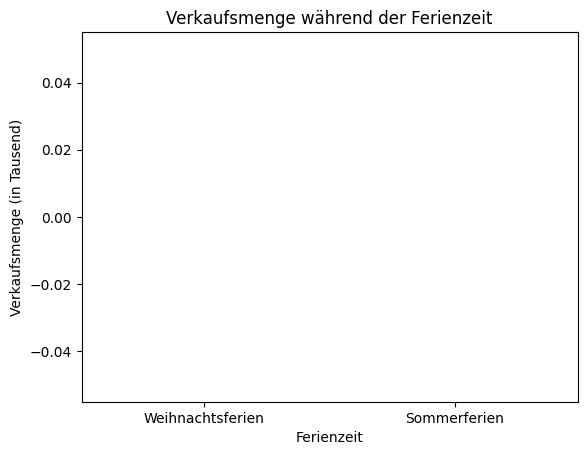

In [138]:


# Daten für Weihnachtsferien filtern und Menge summieren
weihnachtsferien = data[data['Ferienzeit TG'] == 'Weihnachtsferien']
weihnachtsferien_summe = weihnachtsferien['Menge'].sum() / 1000

# Daten für Sommerferien filtern und Menge summieren
sommerferien = data[data['Ferienzeit TG'] == 'Sommerferien']
sommerferien_summe = sommerferien['Menge'].sum() / 1000

# Balkendiagramm erstellen
ferien = ['Weihnachtsferien', 'Sommerferien']
verkaufsmenge = [weihnachtsferien_summe, sommerferien_summe]

plt.bar(ferien, verkaufsmenge)
plt.xlabel('Ferienzeit')
plt.ylabel('Verkaufsmenge (in Tausend)')
plt.title('Verkaufsmenge während der Ferienzeit')
plt.show()


Obwohl die Sommerferien nur doppelt so lange dauern wie die Winterferien, werden ca. drei Mal so viele Backwaren verkauft.

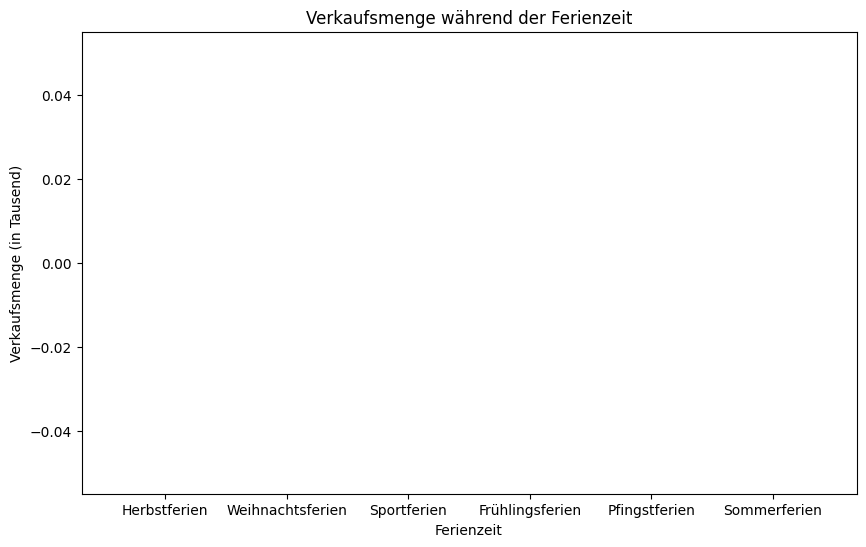

In [139]:
# Liste der Ferienzeiten
ferienzeiten = ['Herbstferien', 'Weihnachtsferien', 'Sportferien', 'Frühlingsferien', 'Pfingstferien', 'Sommerferien']

# Verkaufsmenge für jede Ferienzeit berechnen
verkaufsmenge = []
for ferienzeit in ferienzeiten:
    ferien = data[data['Ferienzeit TG'] == ferienzeit]
    ferien_summe = ferien['Menge'].sum() / 1000
    verkaufsmenge.append(ferien_summe)

# Farben definieren
farben = ['orange', 'red', 'blue', 'green', 'pink', 'yellow']

# Balkendiagramm erstellen
fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(ferienzeiten, verkaufsmenge, color=farben)
ax.set_xlabel('Ferienzeit')
ax.set_ylabel('Verkaufsmenge (in Tausend)')
ax.set_title('Verkaufsmenge während der Ferienzeit')
plt.show()

Man sieht, die Zeit der Sommerferien ist mit Abstand die profitabelste Ferienzeit für die Bäckerei.

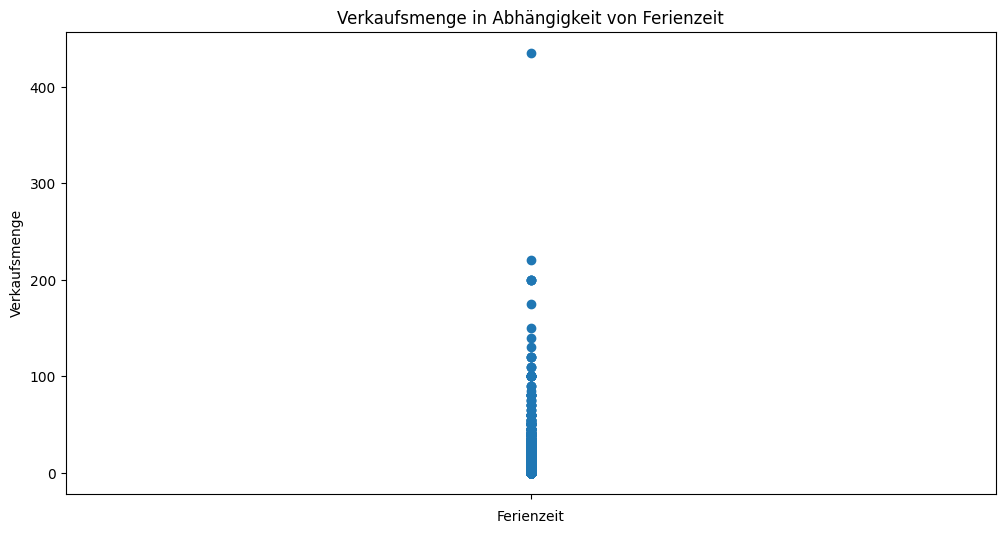

In [140]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(data['Ferienzeit TG'], data['Menge'])
ax.set_title('Verkaufsmenge in Abhängigkeit von Ferienzeit')
ax.set_xlabel('Ferienzeit')
ax.set_ylabel('Verkaufsmenge')
plt.show()

### 2.3.2 Süß und Herzhaft

Wir vermuten einen Zusammenhang zwischen verkaufter Menge und ob ein Produkt süß oder herzhaft ist. Eine Hypothese ist hier beispielsweise, dass an manchen Tagen mehr süße Produkte als Herzhafte Produkte verkauft werden. So könnten Kunden vielleicht Montags eher süßes Gebäck kaufen, weil sie gestresst wegen der Arbeit sind. Genauso gut, könnte ein Peak aber auch richtung Wochenende liegen, da viele sich dann eher etwas süßes vom Bäcker gönnen. 

(Anmerkung: Wir haben die Christliche Fastenzeit nur bis Gründonnerstag beschränkt, obwohl sie streng genommen bis Ostersonntag geht. Grund dafür ist, dass viele Gebäck für die Feiertage im Voraus einkaufen)

In [141]:
# Manuelle Klassifizierung der Produkte in 'süss' und 'herzhaft'
produkte_süß_herzhaft = pd.DataFrame(produkt_liste['Artikel'])
attribute = ['süss', 'herzhaft', 'herzhaft', 'herzhaft', 'herzhaft', 'herzhaft', 'süss', 'süss', 'süss', 'süss', 'süss', 'herzhaft','süss','süss']
produkte_süß_herzhaft['Geschmack'] = attribute
produkte_süß_herzhaft

# Daten mit den manuell klassifizierten Produkten zusammenführen
data = pd.merge(data, produkte_süß_herzhaft, on='Artikel')
data = data.rename(columns={'Geschmack_y': 'Geschmack'})


### 2.3.3 Fastenzeit

Als erstes Fügen wir die Christliche Fastenzeit zum Datensatz hinzu, da wir vermuten, dass einige Menschen in der Fastenzeit zumindest weniger Alkohol und Süßigkeiten konsumieren. 

In [142]:
import datetime 
start_datum = data["Datum"].min()
end_datum = data["Datum"].max()

# Fastenzeit start und Enddaten zwischen 2015 und 2022
fastenzeit = [
    (datetime.date(2015, 2, 18), datetime.date(2015, 4, 2)),
    (datetime.date(2016, 2, 10), datetime.date(2016, 3, 24)),
    (datetime.date(2017, 3, 1), datetime.date(2017, 4, 16)),
    (datetime.date(2018, 2, 14), datetime.date(2018, 3, 29)),
    (datetime.date(2019, 3, 6), datetime.date(2019, 4, 18)),
    (datetime.date(2020, 2, 26), datetime.date(2020, 4, 9)),
    (datetime.date(2021, 2, 17), datetime.date(2021, 4, 1)),
    (datetime.date(2022, 3, 2), datetime.date(2022, 4, 14)),
]
# Function to check if a date is within Lent period
def is_lent(date):
    for start, end in fastenzeit:
        if start <= date <= end:
        
            return 1
    return 0

# Anwendung der Funktion auf die Daten und Erstellung einer neuen Spalte
data['Fastenzeit'] = data['Datum'].apply(is_lent)


Als nächstes fügen wir eine Spalte hinzu die sagt, ob ein Verkauf während des Ramadhans stattgefunden hat. Wir vermuten hier einen Zusammenhang mit den Verkäufen, da sich auch eine Muslimische Gemeinde in der Nähe der Filiale befindet

In [143]:
# Ramadan Start und Enddaten zwischen 2015 und 2022
import datetime 
Ramadan = [
    (datetime.date(2015, 6, 17), datetime.date(2015, 7, 16)),
    (datetime.date(2016, 6, 6), datetime.date(2016, 7, 5)),
    (datetime.date(2017, 5, 26), datetime.date(2017, 6, 24)),
    (datetime.date(2018, 5, 16), datetime.date(2018, 6, 14)),
    (datetime.date(2019, 5, 5), datetime.date(2019, 6, 3)),
    (datetime.date(2020, 4, 23), datetime.date(2020, 5, 23)),
    (datetime.date(2021, 4, 12), datetime.date(2021, 5, 12)),
    (datetime.date(2022, 4, 1), datetime.date(2022, 5, 1)),
]

# Function to check if a date is within Ramadan period
def is_ramadan(date):
    for start, end in Ramadan:
        if start <= date <= end:
       

            return 1
    return 0

# Anwendung der Funktion auf die Daten und Erstellung einer neuen Spalte
data['Ramadan'] = data['Datum'].apply(is_ramadan)

In [144]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 719185 entries, 0 to 719184
Data columns (total 20 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Artikel                      719185 non-null  object  
 1   Menge                        719185 non-null  float64 
 2   Umsatz                       719185 non-null  float64 
 3   Bestellungen                 719185 non-null  float64 
 4   Niederschlag                 716688 non-null  float64 
 5   Temperatur Schnitt Tag       711227 non-null  float64 
 6   Niederschlag Summe Tag       719185 non-null  float64 
 7   Globalstrahlung Schnitt Tag  711227 non-null  float64 
 8   Uhrzeit                      719185 non-null  object  
 9   Stunde                       719185 non-null  int64   
 10  Datum                        719185 non-null  object  
 11  Wochentag                    719185 non-null  category
 12  Monat                        719185 non-null